In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import logging
from pathlib import Path

import numpyro

from hb_mep.config import HBMepConfig
from hb_mep.data_access import DataClass
from hb_mep.models.rats.mixed_effects import MixedEffects
from hb_mep.models.rats.utils import load_data
from hb_mep.utils import plot
from hb_mep.utils.constants import (
    FEATURES
)

numpyro.set_platform("cpu")
numpyro.set_host_device_count(12)
numpyro.enable_x64()

PARENT_PATH = Path(os.getcwd()).parent.parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

#### Load config

In [3]:
config = HBMepConfig()
config.CURRENT_PATH = PARENT_PATH

#### Load data and preprocess

In [4]:
data = DataClass(config)

""" Load """
dir_name = "physio"
participants = range(1, 7)
dir = os.path.join(data.data_path, dir_name)
subdirs_pattern=["*J_RCML*"]

df, mat, time = load_data(dir=dir, subdirs_pattern=subdirs_pattern)

""" Filter: Ground screw """
df[FEATURES[0]] = df.channel2_segment
df[FEATURES[1]] = df.channel2_laterality

idx = df.channel1_segment.isna()

df = df[idx].copy()
df.reset_index(drop=True, inplace=True)

mat = mat[idx, :, :]

""" Ensure both Midline and Lateral are present """
model = MixedEffects(config)

combinations = model._get_combinations(df=df)

keep_combinations = [c for c in combinations if c[-1] == "L" and (c[0], c[1], "M") in combinations]
keep_combinations += [(c[0], c[1], "M") for c in keep_combinations]

df = df[df[model.columns].apply(tuple, axis=1).isin(keep_combinations)].copy()
df.reset_index(drop=True, inplace=True)

""" Preprocess """
df, encoder_dict = data.build(df)

""" Choose muscle """
mat = mat[:, :, 0]


2023-06-14 09:30:57,342 - hb_mep.utils.utils - INFO - func:load_data took: 0.86 sec


IndexError: list index out of range

#### Plot

In [5]:
# plot(df=df, encoder_dict=encoder_dict);

#### Initialize model

In [6]:
model = MixedEffects(config)


#### Run MCMC inference

In [7]:
mcmc, posterior_samples = model.run_inference(df=df)

2023-06-13 15:02:20,391 - hb_mep.models.rats.mixed_effects - INFO - Running inference with Mixed_Effects ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-06-13 15:30:15,118 - hb_mep.utils.utils - INFO - func:run_inference took: 27 min and 54.73 sec


#### Diagnostics

In [8]:
mcmc.print_summary(prob=.95)


                               mean       std    median      2.5%     97.5%     n_eff     r_hat
                 a[0,0,0]    123.71      2.90    123.88    117.75    129.27  17747.61      1.00
                 a[0,0,1]     45.18      1.75     45.35     41.71     48.10  14827.78      1.00
                 a[0,0,2]    213.20     77.02    214.70     48.36    360.11  11735.16      1.00
                 a[0,0,3]     13.37      4.38     13.95      2.35     20.21   4936.55      1.00
                 a[0,0,4]     29.41      1.92     29.35     25.96     34.02   8480.73      1.00
                 a[0,0,5]     70.05      4.16     69.98     61.79     77.53  14479.87      1.00
                 a[0,1,0]    191.58     64.92    192.61     53.28    317.84  13820.54      1.00
                 a[0,1,1]    177.72     73.38    176.53     24.99    316.27  15055.99      1.00
                 a[0,1,2]    213.98     77.59    215.71     50.13    361.32  12274.54      1.00
                 a[0,1,3]     26.69    

#### Recruitment Curves

2023-06-13 15:39:15,772 - hb_mep.utils.utils - INFO - func:plot took: 8 min and 59.43 sec


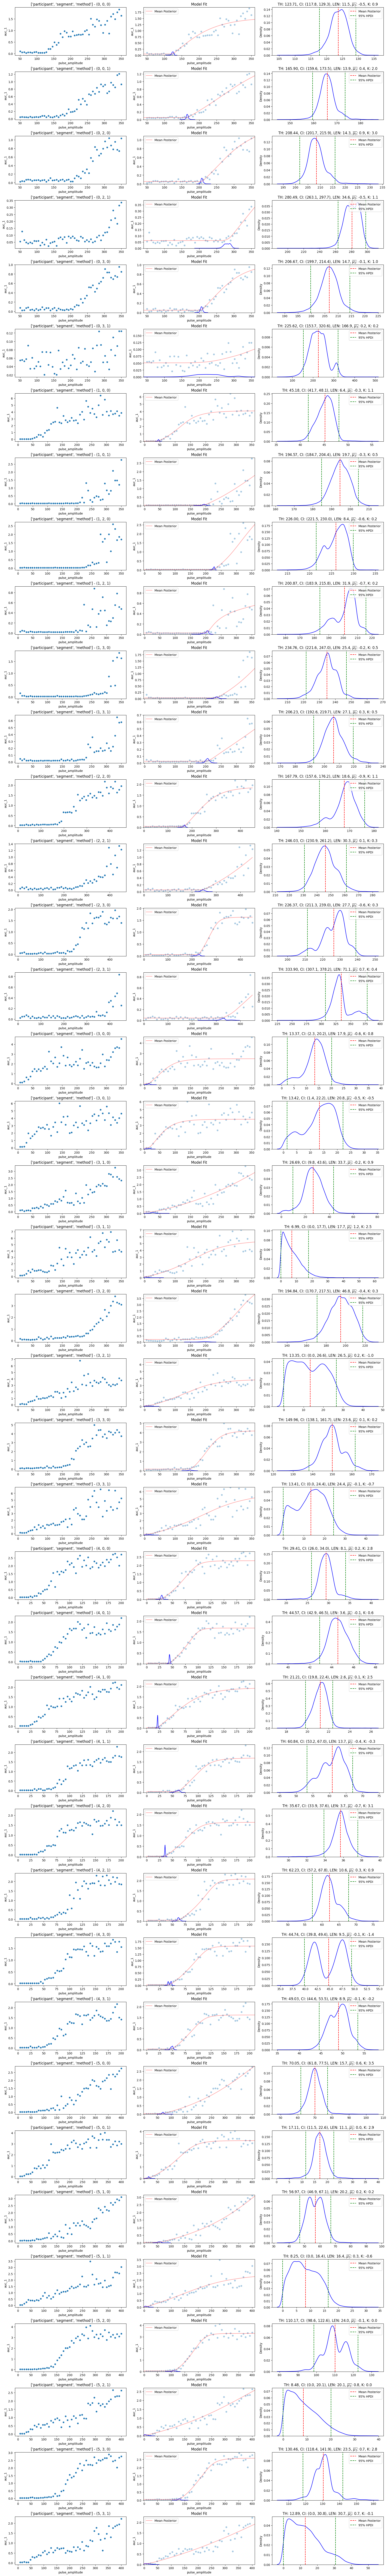

In [9]:
model.plot(df=df, posterior_samples=posterior_samples);

#### Analysis

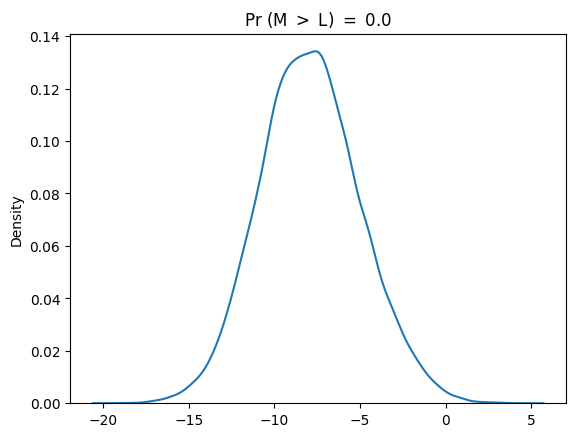

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

m0, m1 = encoder_dict["method"].inverse_transform(np.array([0, 1]))

delta = posterior_samples["delta"]
samples = delta.mean(axis=-1)

sns.kdeplot(samples)
plt.title(f"Pr ({m1} $>$ {m0}) $=$ {(samples.mean() > 1).mean()}");

In [14]:
a = posterior_samples["a"]

In [108]:
(samples > 0).mean()

0.004458333333333333

In [117]:
encoder_dict["method"].inverse_transform(np.array([0, 1]))

array(['L', 'M'], dtype=object)

In [114]:
import scipy.stats as stats

stats.wilcoxon(x=delta2.reshape(-1,), alternative="less")

WilcoxonResult(statistic=53323689827.0, pvalue=0.0)

<Axes: ylabel='Density'>

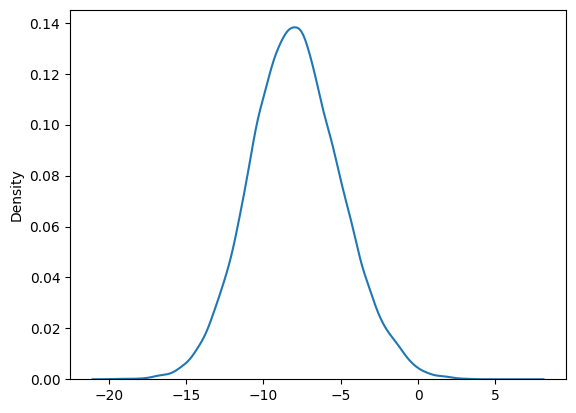

In [107]:
samples = delta2.mean(axis=-1)


sns.kdeplot(samples)

In [79]:
len(keep_combinations)

20

In [72]:
combinations_0

[(0, 0, 0),
 (0, 1, 0),
 (0, 2, 0),
 (0, 3, 0),
 (1, 0, 0),
 (1, 1, 0),
 (1, 2, 0),
 (1, 3, 0),
 (2, 0, 0),
 (2, 1, 0),
 (2, 2, 0),
 (2, 3, 0),
 (3, 0, 0),
 (3, 1, 0),
 (3, 2, 0),
 (3, 3, 0),
 (4, 0, 0),
 (4, 1, 0),
 (4, 2, 0),
 (4, 3, 0),
 (5, 0, 0),
 (5, 1, 0),
 (5, 2, 0),
 (5, 3, 0)]

In [84]:
model.columns

['participant', 'segment', 'method']

In [85]:
combinations = model._get_combinations(df=df)

In [56]:
df["participant"].unique().tolist()

[0, 1, 2, 3, 4, 5]

In [54]:
import numpy as np

np.array([df["segment"].unique().tolist(), df["participant"].unique().tolist()])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [48]:
posterior_samples["a"].shape

(24000, 2, 4, 6)